In [1]:
import sys
import os
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from models.unet.unet import UNet
from src.models.data_management.cnn_formes import CNNFormes
from src.data_processing.dataset_loader import CoastData
from src.models.metrics import Metrics

from src.models.data_management.data_loader import DataLoaderManager

import cv2

c:\Users\josep\.conda\envs\imagine\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(array([0, 1], dtype=uint8), array([65346,   190]))
(array([0., 1.], dtype=float32), array([63675,  1861]))


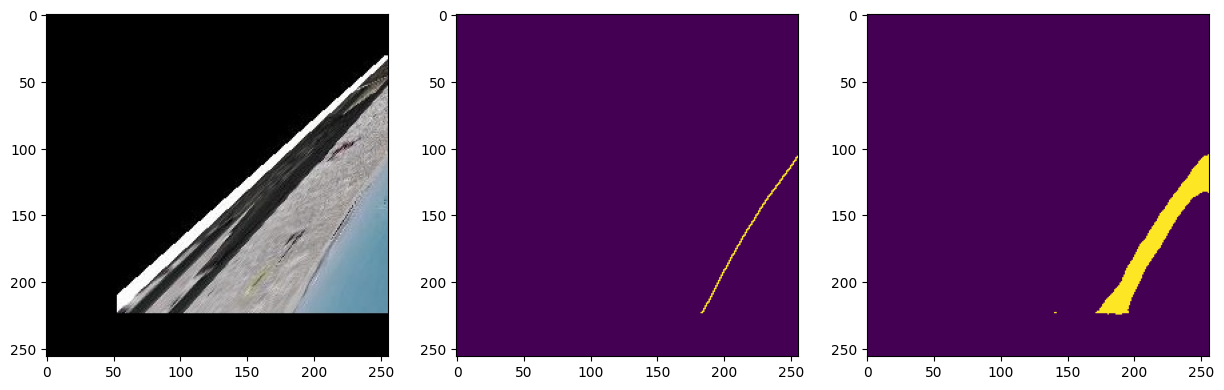

In [2]:
import numpy as np
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))
data = DataLoaderManager.load_data(os.path.abspath(os.path.join(os.getcwd(), "../../data/patchify_shoreline/")))
index = 0
img_path = data["test"]['images'][index]
mask_path = data["test"]['masks'][index]

model = UNet(num_classes=1, experiment_name="test_experiments", use_mlflow=False)
model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-05-06-11-26-35_binary_unet/models/best_model.pth")))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

pred = model.predict(img_path, binary_threshold=0.5)

print(np.unique(mask, return_counts=True))
print(np.unique(pred.cpu(), return_counts=True))


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred.cpu().squeeze())

plt.show()

In [3]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))

num_classes = 1
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

# Load the data to split it and save it to a dict
model = UNet(num_classes=1, experiment_name="test_experiments", use_mlflow=False)

model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-05-06-11-26-35_binary_unet/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_shoreline"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [ ]:
for split in data:
    split = "test"
    print(f"Split: {split}")
    
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max", binary_threshold = 0.50)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())
    break

In [ ]:
for split in data:
    split = "test"
    print(f"Split: {split}")
    
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max", binary_threshold = 0.75)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())
    break

c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\processed_shoreline\images\1549389480.Tue.Feb.05_18_58_00.CET.2019.agrelo.image.jpg


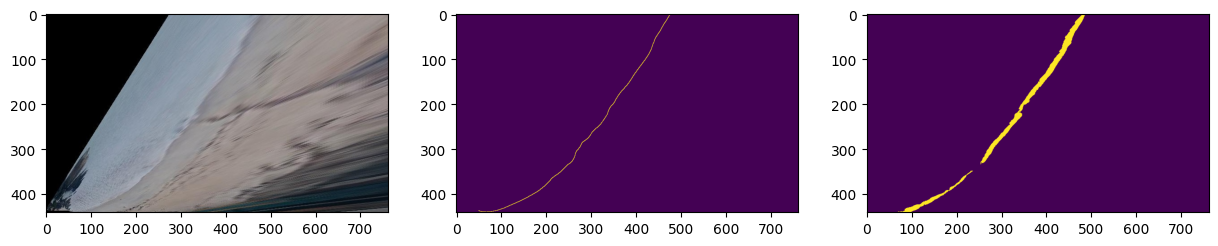

In [7]:
index = 10 # 85

img_path = sorted(data['test']['images'])[index] 
mask_path = sorted(data['test']['masks'])[index]
print(img_path)

pred = model.predict_patch(img_path, combination="avg", patch_size = 256, stride = 128, binary_threshold = 0.89)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred.cpu().squeeze())

plt.show()

# Save the results to an output folder

In [ ]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_shoreline"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

In [ ]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_binary"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [ ]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())

# Search for best threshold

In [6]:
# Data with 4 classes, to be able to compute the shoreline distance

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_shoreline"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [14]:
thresholds = np.linspace(0.5, 0.99999999, num=20)
print(thresholds)

[0.5        0.52631579 0.55263158 0.57894737 0.60526316 0.63157894
 0.65789473 0.68421052 0.71052631 0.7368421  0.76315789 0.78947368
 0.81578947 0.84210526 0.86842105 0.89473683 0.92105262 0.94736841
 0.9736842  0.99999999]


In [16]:
num_classes = 1
metrics = {
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False)
}

for threshold in thresholds:
    split = "test"
    print(f"Split: {split}, threshold: {threshold}")

    metrics = {
        "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False)
    }
    
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max", binary_threshold = threshold)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

Split: test, threshold: 0.5
test metrics: 
	test_accuracy: 0.9017665386199951
	test_f1_score: 0.040179673582315445
	test_precision: 0.020518833771348
	test_recall: 0.9608950614929199
	test_confusion_matrix: 
		0.9016 0.0984
		0.0391 0.9609

Split: test, threshold: 0.5263157889473684
test metrics: 
	test_accuracy: 0.9052640199661255
	test_f1_score: 0.041481051594018936
	test_precision: 0.02119949460029602
	test_recall: 0.9579961895942688
	test_confusion_matrix: 
		0.9052 0.0948
		0.0420 0.9580

Split: test, threshold: 0.5526315778947368
test metrics: 
	test_accuracy: 0.9088402390480042
	test_f1_score: 0.04290156811475754
	test_precision: 0.021943772211670876
	test_recall: 0.9548134207725525
	test_confusion_matrix: 
		0.9087 0.0913
		0.0452 0.9548

Split: test, threshold: 0.5789473668421052
test metrics: 
	test_accuracy: 0.9124934673309326
	test_f1_score: 0.04445156827569008
	test_precision: 0.022757533937692642
	test_recall: 0.951204776763916
	test_confusion_matrix: 
		0.9124 0.0876
		0

In [25]:

threshold = 0.9
split = "test"
print(f"Split: {split}, threshold: {threshold}")

metrics = {
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False)
}

for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
    pred = model.predict_patch(img_path, combination="max", binary_threshold = threshold)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = torch.from_numpy(mask).float() 
    metrics[split].update_metrics(pred, mask)

metrics[split].compute()
print(metrics[split].get_last_epoch_info())

Split: test, threshold: 0.9
test metrics: 
	test_accuracy: 0.9773963093757629
	test_f1_score: 0.10755780339241028
	test_precision: 0.05874156579375267
	test_recall: 0.6365646719932556
	test_confusion_matrix: 
		0.9781 0.0219
		0.3634 0.6366



In [26]:
# Create a folders system to save the results
# SCLabels_prediction_by_set_unet
#   - images
#       - train
#       - validation
#       - test
#   - masks
#       - train
#       - validation
#       - test
#   - predicted_mask
#       - train
#       - validation
#       - test

# Create the folders
subfolders = ["images", "masks", "predicted_mask"]
subset = ["train", "validation", "test"]

path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_binary_0.9"))

os.makedirs(path, exist_ok=True)
for subfolder in subfolders:
    for s in subset:
        os.makedirs(os.path.join(path, subfolder, s), exist_ok=True)

In [27]:
for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max", binary_threshold = 0.9)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Save the images
        img = cv2.imread(img_path)
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        cv2.imwrite(os.path.join(path, "images", split, img_name), img)
        cv2.imwrite(os.path.join(path, "masks", split, mask_name), mask)
        cv2.imwrite(os.path.join(path, "predicted_mask", split, mask_name), pred.cpu().numpy())

Split: train
Split: validation
Split: test
